# Compute seasonal net outgassing of O2 and APO

Start with [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like [util.py](util.py).

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import util

## Connect to catalog

This notebook uses an [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to describe file locations. This is the basis of [intake-esm](https://intake-esm.readthedocs.io/en/latest/), though here we are not using `intake-esm` directly.

In [4]:
%%time
df = pd.read_csv(util.catalog_json)
df

CPU times: user 5.04 s, sys: 405 ms, total: 5.44 s
Wall time: 5.51 s


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r3i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
...,...,...,...,...,...,...,...,...,...,...,...,...
1850252,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,6hrLev,va,gn,NaN,v20200602,209901010600-210001010000,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850253,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,6hrLev,va,gn,NaN,v20200602,210001010600-210101010000,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850254,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Oday,tos,gn,NaN,v20190726,20150101-20491230,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850255,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Oday,tos,gn,NaN,v20190726,20500101-20991230,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...


## Specify a subset of models

In [5]:
models = [
    'CanESM5', ## gives non-monotonic coord error for fgco2 in combine_by_coords below 
    #'CanESM5-CanOE', ## no fgo2 (somehow PM was plotting)
    'CNRM-ESM2-1', 
    'ACCESS-ESM1-5', 
    'MPI-ESM-1-2-HAM', 
    'IPSL-CM6A-LR',
    'MPI-M.MPI-ESM1-2-HR', 
    'MPI-ESM1-2-LR', 
    'NorCPM1', 
    'NorESM2-LM', 
    'UKESM1-0-LL',
    'MIROC-ES2L',
    'MRI-ESM2-0',
]
## others on ESGF showing historical+Omon+fgo2 = EC-Earth3-CC, GFDL-CM4, GFDL-ESM4, IPSL-CM5A2-INCA, IPSL-CM6A-LR-INCA, NorESM2-MM (but of the above ESGF not showing CNRM-ESM2-1, UKESM1-0-LL, MIROC-ES2L, MRI-ESM2-0)


### Test read single model

In [6]:
source_id = 'UKESM1-0-LL'
variable_id = 'fgco2'
time_slice = slice('2005', '2014')
experiment_id = 'historical' 
nmax_members = 4

dsi = util.open_cmip_dataset(
    df=df,
    source_id=source_id, 
    variable_id=variable_id, 
    experiment_id=experiment_id, 
    time_slice=time_slice, 
    table_id='Omon',
    nmax_members=nmax_members,
)
dsi

UKESM1-0-LL, historical, fgco2
	found 13 ensemble members
	reading 4 members: ['r11i1p1f2', 'r12i1p1f2', 'r16i1p1f2', 'r17i1p1f2']



<xarray.Dataset>
Dimensions:    (i: 360, j: 330, member_id: 4, time: 120)
Coordinates:
  * time       (time) object 2005-01-16 00:00:00 ... 2014-12-16 00:00:00
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 322 323 324 325 326 327 328 329
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float32 -84.11 -84.11 -84.11 -84.11 ... 50.51 50.23 50.01
    longitude  (j, i) float32 73.5 74.5 75.5 76.5 ... 72.93 72.95 72.96 72.99
    depth      float64 0.0
  * member_id  (member_id) <U9 'r11i1p1f2' 'r12i1p1f2' 'r16i1p1f2' 'r17i1p1f2'
Data variables:
    fgco2      (member_id, time, j, i) float64 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  219600.0
    creation_date:          2019-12-05T11:43:58Z
    ...                     ...
    variable_id:            fgco2
    variable_name:          fgco2
    variant_label:          r11i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b8fceaab-f35a-47d1-a4ca-0c57d4b73857

## Get grid data from each model

Skip models where the grid data is not available

In [7]:
dsets_fix = {}
grid_variables = ['areacello',]
for model in models:
    dsets_m = [util.get_gridvar(df, model, v) for v in grid_variables]
    dsets_m = [ds for ds in dsets_m if ds is not None]
    if dsets_m:
        dsets_fix[model] = xr.merge(dsets_m)
        dsets_fix[model].attrs['source_id'] = model
        
list(dsets_fix.keys())
## somehow PM was getting areacello for MPI-M.MPI-ESM1-2-HR from Ofx - I tried specifying table_id as Ofx here but that did not help

MPI-M.MPI-ESM1-2-HR: missing "areacello"
NorCPM1: missing "areacello"


['CanESM5',
 'CNRM-ESM2-1',
 'ACCESS-ESM1-5',
 'MPI-ESM-1-2-HAM',
 'IPSL-CM6A-LR',
 'MPI-ESM1-2-LR',
 'NorESM2-LM',
 'UKESM1-0-LL',
 'MIROC-ES2L',
 'MRI-ESM2-0']

## Compute a region mask for integration

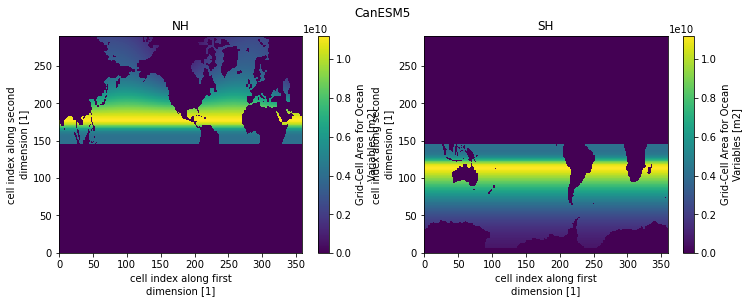

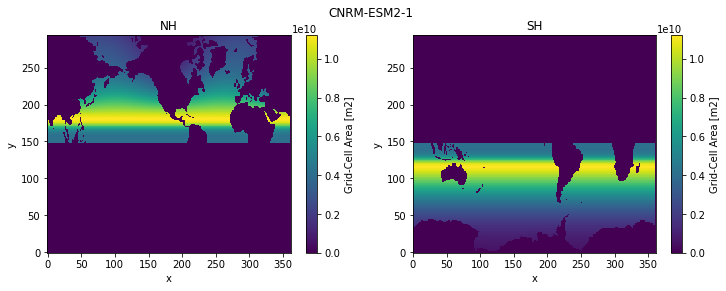

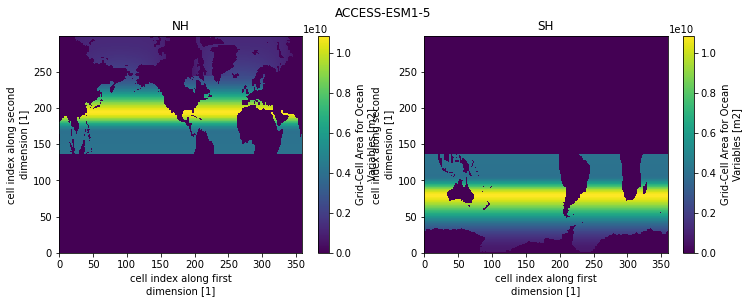

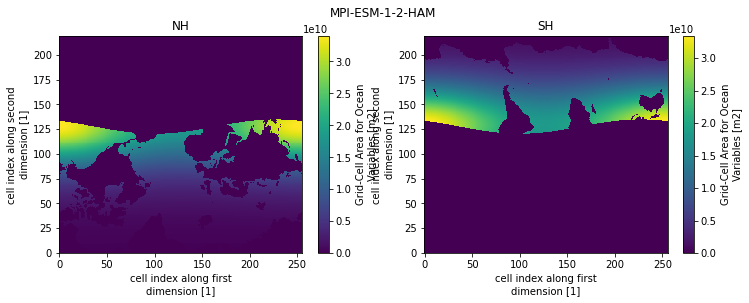

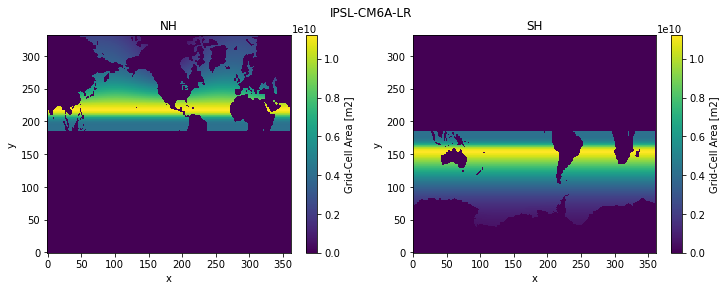

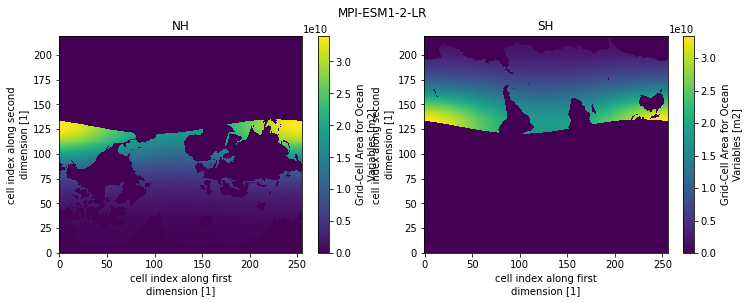

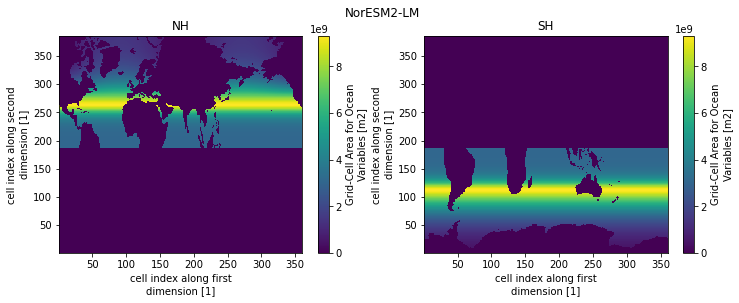

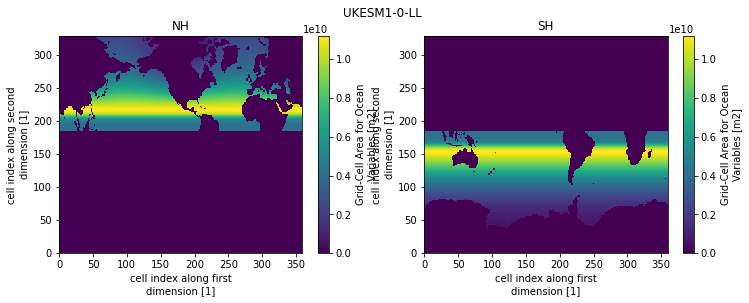

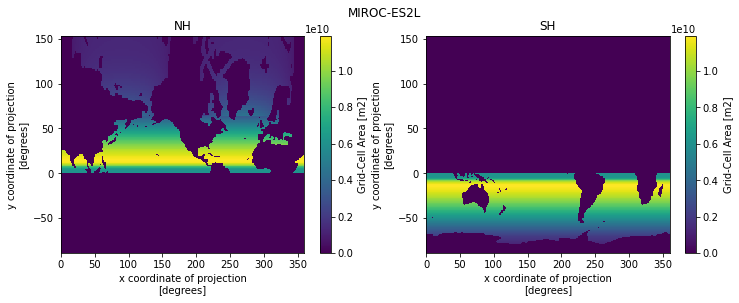

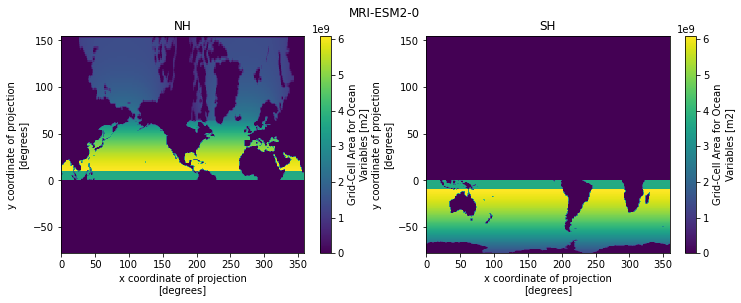

In [8]:
#rmask_definition = 'SET_NET'
rmask_definition = 'SH_NH' ### grid-cell area is maxing at 20 degrees in each hemisphere

rmask_dict = {}
for model in models:    
    if model not in dsets_fix:
        continue
    rmask_dict[model] = util.get_rmask_dict(
        dsets_fix[model], 
        mask_definition=rmask_definition, 
        plot=True
    )    

## Assemble monthly-mean climatology

This code takes the following steps:
- Read a dataset for each model
- Compute the regional integral 
- Compute the mean for each month and average across ensemble members
- Concatenate the resulting timeseries along a `source_id` dimension

Note that the code is set up to cache the resulting dataset; it will optionally read this dataset, rather than recreate it, if it exists.

In [20]:
%%time

variable_ids = ['fgco2', 'fgo2']
    
time_slice = slice('2005', '2014') ## for comparison to HIPPO/ORCAS/ATom 2009-2018, pick closest decade
experiment_id = 'historical' 
nmax_members = 4
clobber = True

# specify models for each variable that have reverse sign convention
models_flipsign = {v: [] for v in variable_ids}
models_flipsign['fgo2'] = ['NorESM2-LM',]


ds_list = []
source_id_list = []
for source_id in models:    
    if source_id not in rmask_dict:
        continue
        
    ds_list_variable_ids = []
    for variable_id in variable_ids:
        cache_file = (
            f'data/cmip6'
            f'.{source_id}'
            f'.{experiment_id}'
            f'.{variable_id}'
            f'.{rmask_definition}'
            f'.monclim_{time_slice.start}-{time_slice.stop}.zarr'
        )
        
        if os.path.exists(cache_file) and not clobber:
            ds = xr.open_zarr(cache_file)

        else:
           
            dsi = util.open_cmip_dataset(
                df=df,
                source_id=source_id, 
                variable_id=variable_id, 
                experiment_id=experiment_id, 
                table_id='Omon',
                time_slice=time_slice, 
                nmax_members=nmax_members,
            )
            if dsi is None:
                print(f'missing: {source_id}, {experiment_id}, {variable_id}')
                continue

            # compute the regional integrals
            flipsign = True if source_id in models_flipsign[variable_id] else False            
            da = util.compute_regional_integral(
                ds=dsi, 
                variable_id=variable_id,
                rmasks=rmask_dict[source_id],
                flipsign=flipsign,
            )    
            
            with xr.set_options(keep_attrs=True):
                da = da.groupby('time.month').mean().mean('member_id')
            
            ds = da.to_dataset().drop(['depth']).compute()
            ds.to_zarr(cache_file, mode='w');            
            
        ds_list_variable_ids.append(ds)
    
    if ds_list_variable_ids:
        source_id_list.append(source_id)

    # merge across variables
    ds_list.append(xr.merge(ds_list_variable_ids,))

ds = xr.concat(ds_list, dim=xr.DataArray(source_id_list, dims=('source_id'), name='source_id'))    
ds

CanESM5, historical, fgco2
	found 50 ensemble members
	reading 50 members: ['r10i1p1f1', 'r10i1p2f1', 'r11i1p1f1', 'r11i1p2f1', 'r12i1p1f1', 'r12i1p2f1', 'r13i1p1f1', 'r13i1p2f1', 'r14i1p1f1', 'r14i1p2f1', 'r15i1p1f1', 'r15i1p2f1', 'r16i1p1f1', 'r16i1p2f1', 'r17i1p1f1', 'r17i1p2f1', 'r18i1p1f1', 'r18i1p2f1', 'r19i1p1f1', 'r19i1p2f1', 'r1i1p1f1', 'r1i1p2f1', 'r20i1p1f1', 'r20i1p2f1', 'r21i1p1f1', 'r21i1p2f1', 'r22i1p1f1', 'r22i1p2f1', 'r23i1p1f1', 'r23i1p2f1', 'r24i1p1f1', 'r24i1p2f1', 'r25i1p1f1', 'r25i1p2f1', 'r2i1p1f1', 'r2i1p2f1', 'r3i1p1f1', 'r3i1p2f1', 'r4i1p1f1', 'r4i1p2f1', 'r5i1p1f1', 'r5i1p2f1', 'r6i1p1f1', 'r6i1p2f1', 'r7i1p1f1', 'r7i1p2f1', 'r8i1p1f1', 'r8i1p2f1', 'r9i1p1f1', 'r9i1p2f1']
open_mfdataset failed.
/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/historical/r24i1p2f1/Omon/fgco2/gn/v20190429/fgco2/fgco2_Omon_CanESM5_historical_r24i1p2f1_gn_185001-201412.nc


KeyboardInterrupt: 

## Make some plots

In [17]:
monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

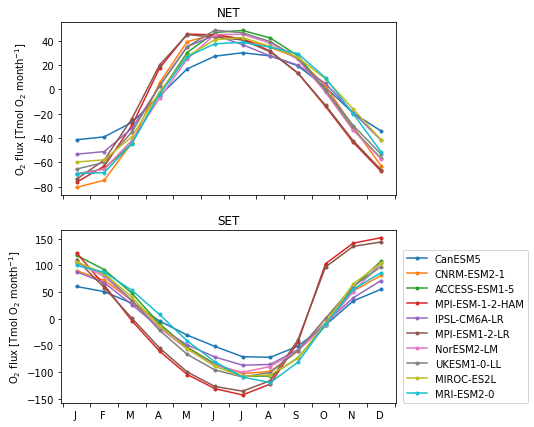

In [18]:
field = 'fgo2'

fig, axs = plt.subplots(2, 1, figsize=(6, 7), facecolor='w')
    
for region, ax in zip(ds.region.values, axs.ravel()):
    for source_id in ds.source_id.values:
        ax.plot(
            ds.month-0.5, 
            ds[field].sel(source_id=source_id, region=region), 
            marker='.', 
            linestyle='-',
            label=source_id,
        )

    ax.set_xticks(np.arange(13))    
    ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
    ax.set_title(region);
    ax.set_xticklabels([])
ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
ax.legend(loc=(1.02, 0));

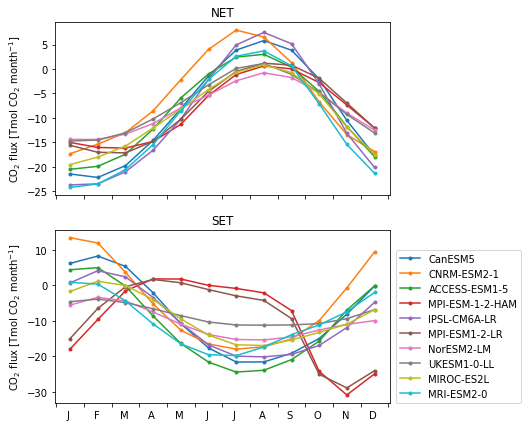

In [19]:
field = 'fgco2'

fig, axs = plt.subplots(2, 1, figsize=(6, 7), facecolor='w')
    
monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

for region, ax in zip(ds.region.values, axs.ravel()):
    for source_id in ds.source_id.values:
        ax.plot(
            ds.month-0.5, 
            ds[field].sel(source_id=source_id, region=region), 
            marker='.', 
            linestyle='-',
            label=source_id,
        )

    ax.set_xticks(np.arange(13))    
    ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
    ax.set_title(region);
    ax.set_xticklabels([])
    
ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
ax.legend(loc=(1.02, 0));